<a href="https://colab.research.google.com/github/sayakpaul/Revisiting-Pooling-in-CNNs/blob/main/SoftPool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements the SoftPool layer as proposed in the [Refining activation downsampling with SoftPool](https://arxiv.org/pdf/2101.00440.pdf) paper. We will also see how to use its 2D variant inside a shallow CNN and train the network. We will be using the CIFAR10 dataset for this purpose.  

## Initial Setup

In [1]:
!nvidia-smi

Tue Jan 26 05:53:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.random.set_seed(666)
print(tf.__version__)

2.4.0


In [9]:
import matplotlib.pyplot as plt
import time

## CIFAR10 dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Preprocessing Utilities

In [5]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

@tf.function
def preprocess_image(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Layer and Model Definitions

In [6]:
# Reference:
# https://github.com/qwopqwop200/SoftPool/blob/main/tensorflow_softpool.py#L14-#L22
class SoftPooling2D(tf.keras.layers.Layer):
    """Implements SoftPool as proposed in https://arxiv.org/pdf/2101.00440.pdf."""
    def __init__(self,pool_size=(2, 2),strides=None,padding='valid',data_format=None):
        super(SoftPooling2D, self).__init__()
        self.avgpool = tf.keras.layers.AvgPool2D(pool_size,strides,padding,data_format)
    def call(self, x):
        x_exp = tf.math.exp(x)
        x_exp_pool = self.avgpool(x_exp)
        x = self.avgpool(x_exp*x)
        return x/x_exp_pool

**Note**: All the hyperparameters like `strides`, `pool_size`, `padding` have been set to their default specifications. 

In [12]:
# Reference:
# https://github.com/ayulockin/LossLandscape/blob/master/MediumCNN_Cifar10.ipynb
def get_training_model(pool_type=tf.keras.layers.MaxPool2D):
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = pool_type()(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = pool_type()(x)

    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = pool_type()(x)

    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = pool_type()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

## Model Training Utilities

In [10]:
def plot_training(H):
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [14]:
# Early stopping callback to prevent from overfitting
es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

## Model Training

Epoch 1/40
391/391 [==============================] - 4s 9ms/step - loss: 1.9429 - accuracy: 0.2797 - val_loss: 1.4975 - val_accuracy: 0.4790
Epoch 2/40
391/391 [==============================] - 4s 9ms/step - loss: 1.3792 - accuracy: 0.5006 - val_loss: 1.2124 - val_accuracy: 0.5812
Epoch 3/40
391/391 [==============================] - 4s 9ms/step - loss: 1.1598 - accuracy: 0.5833 - val_loss: 1.0559 - val_accuracy: 0.6427
Epoch 4/40
391/391 [==============================] - 4s 9ms/step - loss: 1.0324 - accuracy: 0.6359 - val_loss: 0.9410 - val_accuracy: 0.6810
Epoch 5/40
391/391 [==============================] - 4s 9ms/step - loss: 0.9283 - accuracy: 0.6751 - val_loss: 0.8973 - val_accuracy: 0.6939
Epoch 6/40
391/391 [==============================] - 4s 9ms/step - loss: 0.8423 - accuracy: 0.7054 - val_loss: 0.8482 - val_accuracy: 0.7128
Epoch 7/40
391/391 [==============================] - 4s 9ms/step - loss: 0.7666 - accuracy: 0.7336 - val_loss: 0.7864 - val_accuracy: 0.7327
Epoch 

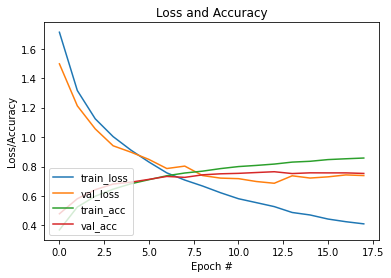

79/79 [==============================] - 0s 6ms/step - loss: 0.6864 - accuracy: 0.7647
Final test accuracy: 76.470%


In [24]:
# MaxPooling
max_pool_model = get_training_model()
max_pool_model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = max_pool_model.fit(trainloader,
                        epochs=40,
                        validation_data=testloader,
                        callbacks=[es])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(history)
acc = max_pool_model.evaluate(testloader)[1]
print("Final test accuracy: {:.3f}%".format(acc*100))

Epoch 1/40
391/391 [==============================] - 6s 12ms/step - loss: 1.9881 - accuracy: 0.2611 - val_loss: 1.5188 - val_accuracy: 0.4544
Epoch 2/40
391/391 [==============================] - 5s 12ms/step - loss: 1.4970 - accuracy: 0.4506 - val_loss: 1.3855 - val_accuracy: 0.5056
Epoch 3/40
391/391 [==============================] - 5s 12ms/step - loss: 1.3553 - accuracy: 0.5118 - val_loss: 1.2434 - val_accuracy: 0.5627
Epoch 4/40
391/391 [==============================] - 5s 12ms/step - loss: 1.2307 - accuracy: 0.5579 - val_loss: 1.1341 - val_accuracy: 0.5971
Epoch 5/40
391/391 [==============================] - 5s 12ms/step - loss: 1.1390 - accuracy: 0.5953 - val_loss: 1.0442 - val_accuracy: 0.6309
Epoch 6/40
391/391 [==============================] - 5s 12ms/step - loss: 1.0650 - accuracy: 0.6256 - val_loss: 1.0207 - val_accuracy: 0.6457
Epoch 7/40
391/391 [==============================] - 5s 12ms/step - loss: 1.0012 - accuracy: 0.6467 - val_loss: 0.9700 - val_accuracy: 0.6604

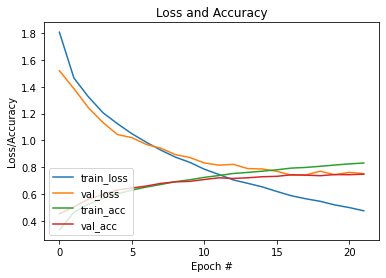

79/79 [==============================] - 0s 5ms/step - loss: 0.7422 - accuracy: 0.7439
Final test accuracy: 74.390%


In [25]:
# SoftPooling
soft_pool_model = get_training_model(pool_type=SoftPooling2D)
soft_pool_model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = soft_pool_model.fit(trainloader,
                        epochs=40,
                        validation_data=testloader,
                        callbacks=[es])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(history)
acc = soft_pool_model.evaluate(testloader)[1]
print("Final test accuracy: {:.3f}%".format(acc*100))